# Machine Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
# configure matplotlib output
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
%matplotlib inline

In [3]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [4]:
# warnings are again annoying
import warnings
warnings.filterwarnings('ignore')

## Regression

$$\log(\mathcal{L}) = -\frac{N}{2}\log(2\pi)-N\log(\sigma)-\sum_i \frac{1}{2}\left(\frac{y_i-\beta x_i}{\sigma}\right)^2$$

In [5]:
# generate random data
N = 1000
dat_x = torch.randn(N)
dat_y = 3 + 2*dat_x + 0.5*torch.randn(N)

2.992964267730713 1.9935076236724854


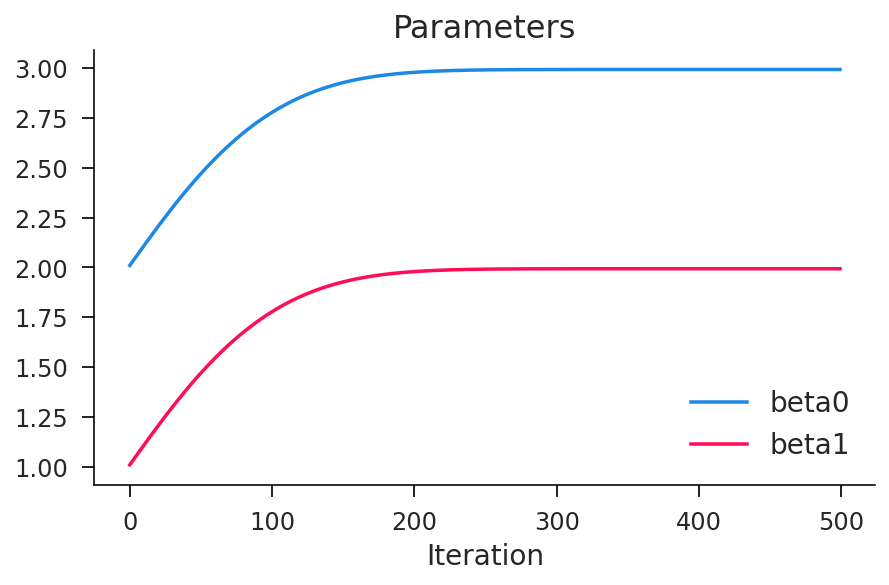

In [6]:
# these are symbols representing our regression coefficients
beta0 = torch.tensor(2.0, dtype=torch.float, requires_grad=True)
beta1 = torch.tensor(1.0, dtype=torch.float, requires_grad=True)
optim = torch.optim.Adam([beta0, beta1], lr=0.01)

# save history of training (the old fashioned way)
history = []

# run for a fixed period and hope for convergence
for i in range(500):
    # compute likelihood
    pred = beta0 + beta1*dat_x
    loss = (pred-dat_y).square().mean()

    # compute gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    # save param path
    history.append({
        'beta0': beta0.detach().item(),
        'beta1': beta1.detach().item(),
    })

# get betas as scalars
beta0 = beta0.detach().item()
beta1 = beta1.detach().item()
print(beta0, beta1)

# turn history into dataframe
history = pd.DataFrame(history)
history.plot(title='Parameters', xlabel='Iteration', figsize=(7, 4));

## Classification

In [7]:
dim = 100
fdim = torch.tensor(dim, dtype=torch.float)
bool_mean = lambda x: x.to(dtype=torch.float).mean()
get_scalar = lambda x: x.detach().item()

In [8]:
def batcher(dat, bs=1000):
    nmax, *_ = dat[0].shape
    i = 0
    while i < nmax:
        yield [x[i:i+bs] for x in dat]
        i += bs

In [9]:
def binary_crossentropy(logits, y):
    probs = 1/(1+torch.exp(-logits))
    like = torch.where(y, probs, 1-probs)
    return torch.log(like)

In [10]:
def logit_predict(beta0, beta1, x):
    return beta0 + x @ beta1

In [11]:
def logit_loss(beta0, beta1, x, y):
    logits = logit_predict(beta0, beta1, x)
    like = binary_crossentropy(logits, y)
    return -like.mean()

In [12]:
def logit_stats(beta0, beta1, x, y):
    # coefficient distribution
    b1avg = beta1.mean()
    b1std = (beta1.square().mean()-b1avg.square()).sqrt()

    # prediction
    logits = logit_predict(beta0, beta1, x)
    predict = logits >= 0.0 # point prediction in {0,1}
    predavg = bool_mean(predict)

    # fit assessment
    accuracy = bool_mean(predict == y)
    false_pos = bool_mean(predict & ~y)
    false_neg = bool_mean(~predict & y)

    # return detached
    stats = {
        'beta0': beta0, 'b1avg': b1avg, 'b1std': b1std, 'accuracy': accuracy,
        'false_pos': false_pos, 'false_neg': false_neg
    }
    return {k: get_scalar(v) for k, v in stats.items()}

In [13]:
def logistic_regression(x_data, y_data, K=100, lr=0.01):
    N, M = x_data.shape

    # these are our regression coefficients
    beta0 = torch.tensor(0.1*torch.randn(1).squeeze(), requires_grad=True)
    beta1 = torch.tensor(0.1*torch.randn(M), requires_grad=True)
    optim = torch.optim.Adam([beta0, beta1], lr=lr)

    # save history of training (the old fashioned way)
    history = []

    # run for a fixed period and hope for convergence
    for i in range(K):
        for x, y in batcher((x_data, y_data)):
            like = logit_loss(beta0, beta1, x, y)
            optim.zero_grad()
            like.backward()
            optim.step()

        stats = logit_stats(beta0, beta1, x_data, y_data)
        history.append(stats)

    # return results
    return (beta0, beta1), pd.DataFrame(history)

### Linear Data

In [14]:
# simple hyperplane model
true_beta0 = 0.0
true_beta1 = 1.0*torch.ones(dim)

In [15]:
N = 10000
space = torch.randn(N, dim)
rando = torch.tensor(np.random.logistic(size=N))
categ = true_beta0 + space @ true_beta1 + rando > 0
print(bool_mean(categ))

tensor(0.5104)


In [16]:
(est_beta0, est_beta1), history = logistic_regression(space, categ, K=250, lr=0.01)
print(f'beta0 = {est_beta0}')
print(f'b1avg = {est_beta1.mean()}')
print(f'b1std = {est_beta1.std()}')

beta0 = 0.056662414222955704
b1avg = 1.039868950843811
b1std = 0.05744213983416557


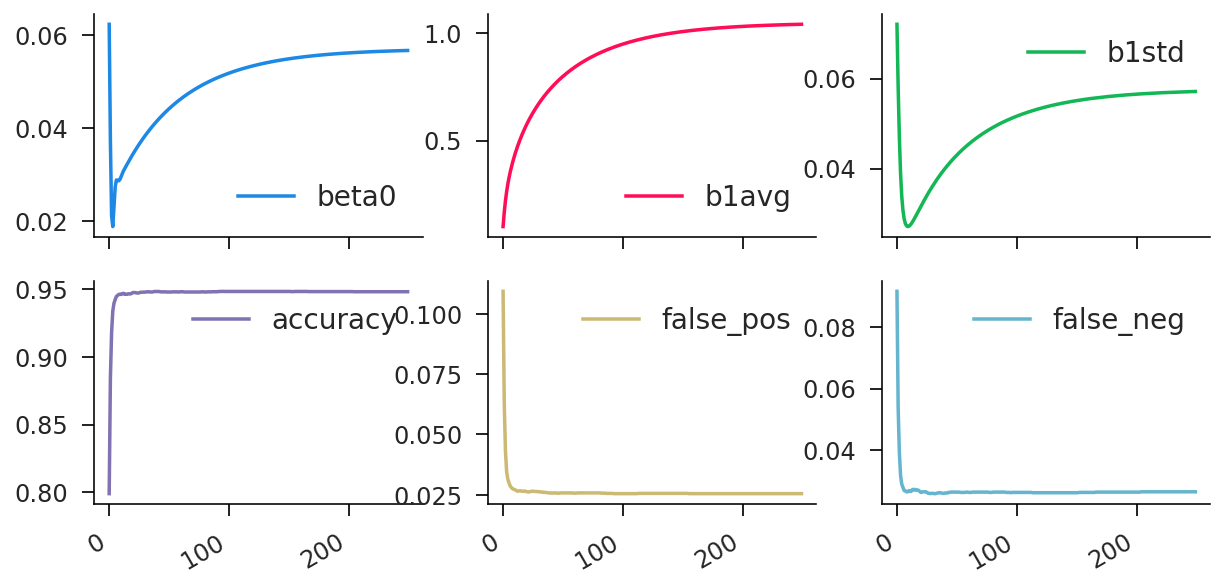

In [17]:
history.plot(subplots=True, layout=(2, 3), figsize=(10, 5));

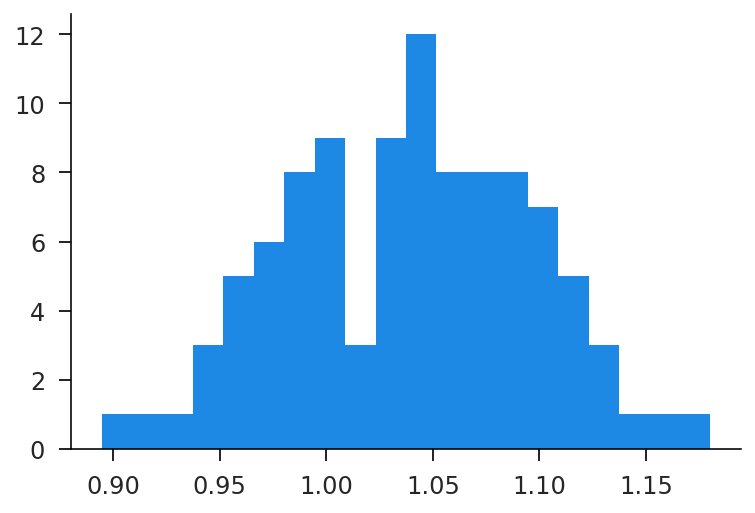

In [18]:
plt.hist(est_beta1.detach().numpy(), bins=20);

In [19]:
# look at out of sample properties (validation accuracy)
val_space = torch.randn(N, dim)
val_rando = torch.tensor(np.random.logistic(size=N))
val_categ = true_beta0 + val_space @ true_beta1 + val_rando > 0
val_stats = logit_stats(est_beta0, est_beta1, val_space, val_categ)
print('\n'.join([f'{k} = {v}' for k, v in val_stats.items()]))

beta0 = 0.056662414222955704
b1avg = 1.039868950843811
b1std = 0.0571560263633728
accuracy = 0.9423999786376953
false_pos = 0.029500000178813934
false_neg = 0.02810000069439411


### Non-linear data

In [20]:
N = 10000
space = torch.randn(N, dim)
categ = space.square().sum(axis=1).sqrt() < fdim.sqrt()
print(bool_mean(categ))

tensor(0.5225)


In [21]:
(est_beta0, est_beta1), history = logistic_regression(space, categ, K=100)
print(f'beta0 = {est_beta0}')
print(f'b1avg = {est_beta1.mean()}')
print(f'b1std = {est_beta1.std()}')

beta0 = 0.09623882919549942
b1avg = 0.004389282315969467
b1std = 0.01950017921626568


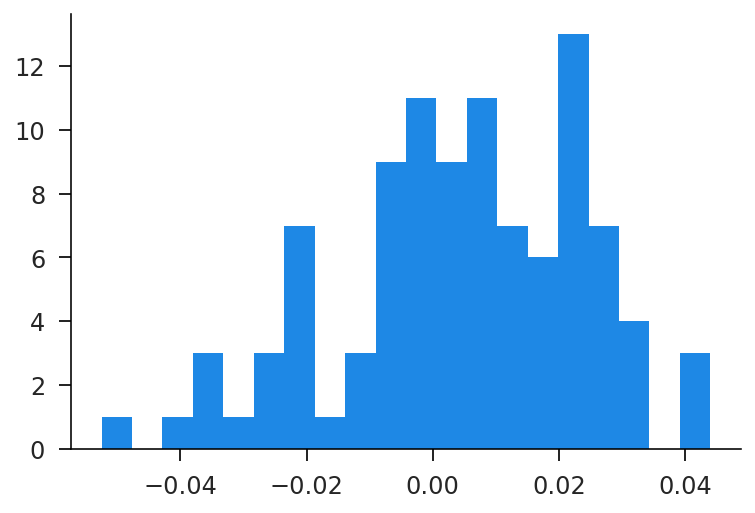

In [22]:
plt.hist(est_beta1.detach().numpy(), bins=20);

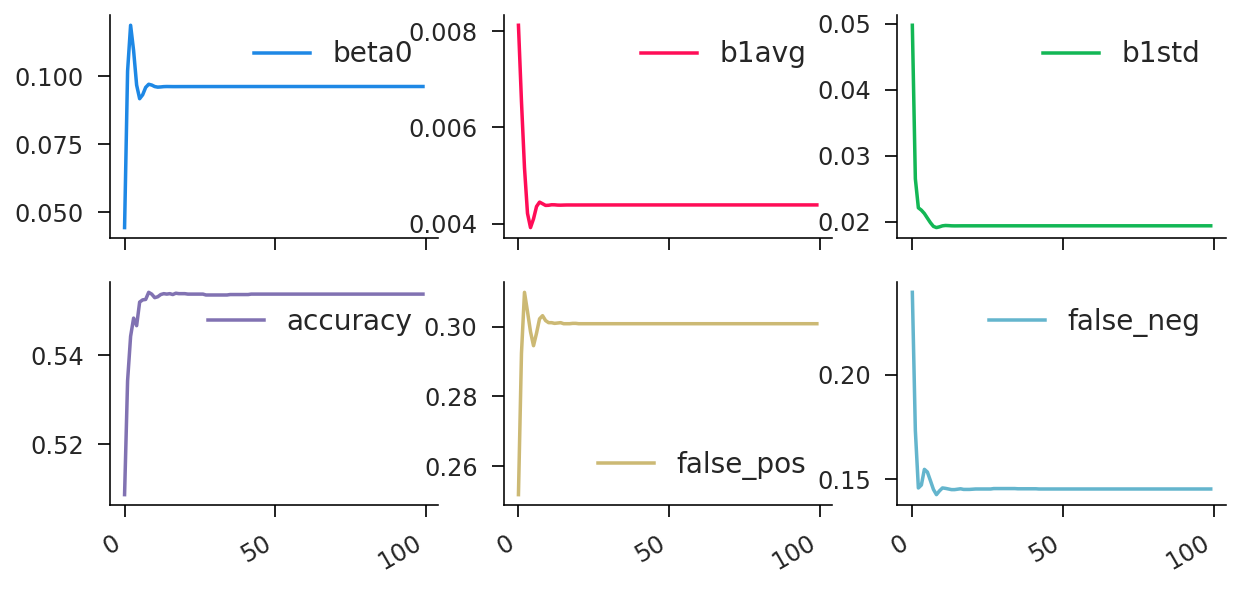

In [23]:
history.plot(subplots=True, layout=(2, 3), figsize=(10, 5));

In [24]:
# look at out of sample properties (validation accuracy)
val_space = torch.randn(N, dim)
val_categ = val_space.square().sum(axis=1).sqrt() < fdim.sqrt()
val_stats = logit_stats(est_beta0, est_beta1, val_space, val_categ)
print('\n'.join([f'{k} = {v}' for k, v in val_stats.items()]))

beta0 = 0.09623882919549942
b1avg = 0.004389282315969467
b1std = 0.019402433186769485
accuracy = 0.5102999806404114
false_pos = 0.33730000257492065
false_neg = 0.15240000188350677


### Neural Networks

In [25]:
N = 10000
hill_func = lambda dat: dat[:, 1] >= 2.5*dat[:, 0]*(1-dat[:, 0])
train_space = torch.rand(N, 2)
train_categ = hill_func(train_space)
valid_space = torch.rand(1000, 2)
valid_categ = hill_func(valid_space)

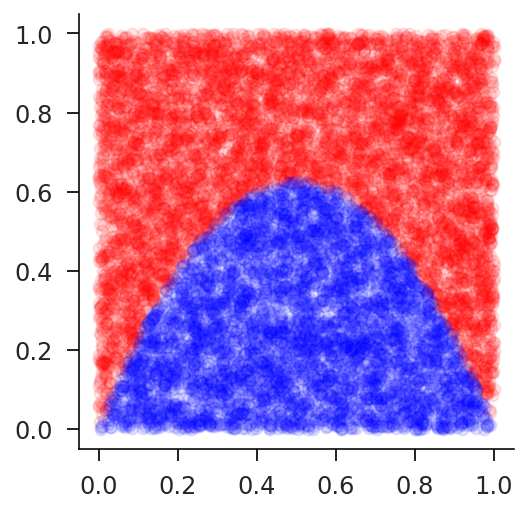

In [26]:
red_space = train_space[train_categ, :]
blue_space = train_space[~train_categ, :]
fig, ax = plt.subplots()
ax.scatter(red_space[:, 0], red_space[:, 1], alpha=0.1, color='red');
ax.scatter(blue_space[:, 0], blue_space[:, 1], alpha=0.1, color='blue');
plt.axis('square');

In [27]:
def neural_predict(W0, b0, W1, b1, x):
    hidden = torch.sigmoid(x @ W0 + b0)
    output = hidden @ W1 + b1
    return output.squeeze()

In [28]:
def neural_loss(W0, b0, W1, b1, x, y):
    logits = neural_predict(W0, b0, W1, b1, x)
    like = binary_crossentropy(logits, y)
    return -like.mean()

In [29]:
def neural_stats(W0, b0, W1, b1, x, y):
    # generate predictions
    logits = neural_predict(W0, b0, W1, b1, x)
    predict = logits >= 0.0 # point prediction in {0,1}
    predavg = bool_mean(predict)

    # fit assessment
    accuracy = bool_mean(predict == y)
    false_pos = bool_mean(predict & ~y)
    false_neg = bool_mean(~predict & y)

    # return detached
    stats = {
        'accuracy': accuracy, 'false_pos': false_pos, 'false_neg': false_neg
    }
    return {k: get_scalar(v) for k, v in stats.items()}

In [30]:
def neural_regression(train_x, train_y, valid_x, valid_y, K=100, lr=0.01, hid=2):
    # these are symbols representing our network weights
    W0 = torch.tensor(torch.randn((2, hid), dtype=torch.float), requires_grad=True)
    b0 = torch.tensor(torch.randn((1, hid), dtype=torch.float), requires_grad=True)
    W1 = torch.tensor(torch.randn((hid, 1), dtype=torch.float), requires_grad=True)
    b1 = torch.tensor(torch.randn((1, 1), dtype=torch.float), requires_grad=True)
    optim = torch.optim.Adam([W0, b0, W1, b1], lr=lr)

    # save history of training (the old fashioned way)
    train_hist = []
    valid_hist = []

    # run for a fixed period and hope for convergence
    for i in range(K):
        for x, y in batcher((train_x, train_y)):
            like = neural_loss(W0, b0, W1, b1, x, y)
            optim.zero_grad()
            like.backward()
            optim.step()

        train_stats = neural_stats(W0, b0, W1, b1, train_x, train_y)
        valid_stats = neural_stats(W0, b0, W1, b1, valid_x, valid_y)
        train_hist.append(train_stats)
        valid_hist.append(valid_stats)

    # turn history into dataframe
    params = [p.detach() for p in (W0, b0, W1, b1)]
    history = pd.concat([
        pd.DataFrame(train_hist).add_prefix('train_'),
        pd.DataFrame(valid_hist).add_prefix('valid_'),
    ], axis=1)
    
    # return results
    return params, history

In [36]:
(est_W0, est_b0, est_W1, est_b1), history = neural_regression(
    train_space, train_categ, valid_space, valid_categ, K=500
)
history.iloc[-1]

train_accuracy     0.9799
train_false_pos    0.0116
train_false_neg    0.0085
valid_accuracy     0.9800
valid_false_pos    0.0150
valid_false_neg    0.0050
Name: 499, dtype: float64

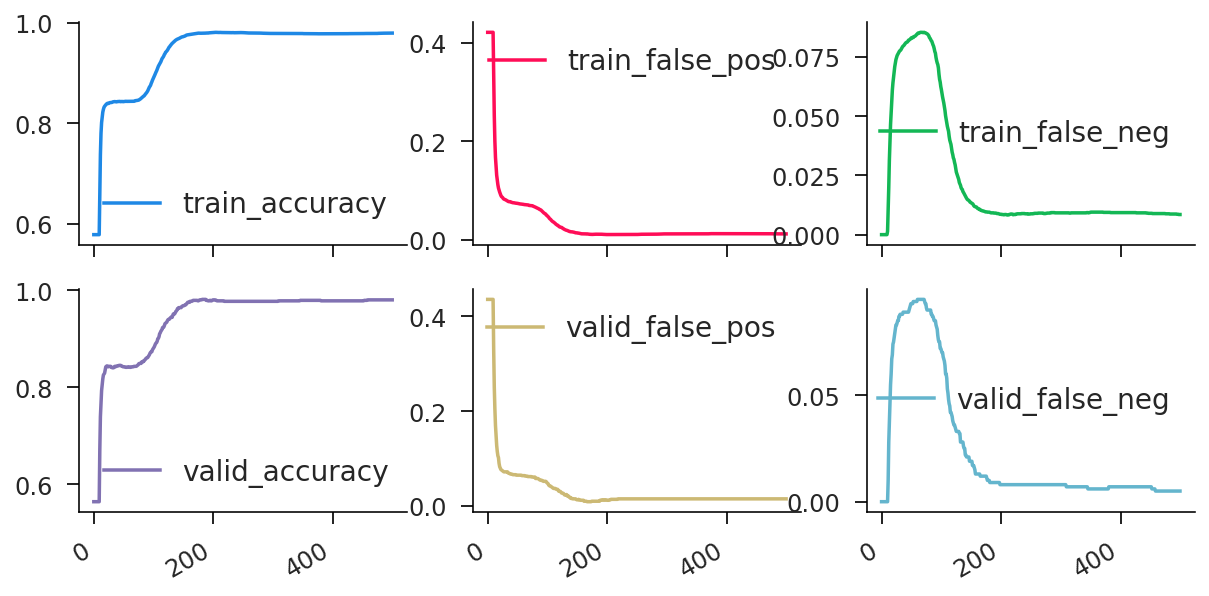

In [37]:
history.plot(subplots=True, layout=(2, 3), figsize=(10, 5));

In [38]:
# construct uniform grid over (x, y)
M = 100
test_a = torch.linspace(0, 1, M)
test_b = torch.linspace(0, 1, M)
test_x = torch.cartesian_prod(test_a, test_b)
test_logits = neural_predict(est_W0, est_b0, est_W1, est_b1, test_x)
test_pred = test_logits >= 0.0
test_red = test_x[test_pred, :]
test_blue = test_x[~test_pred, :]

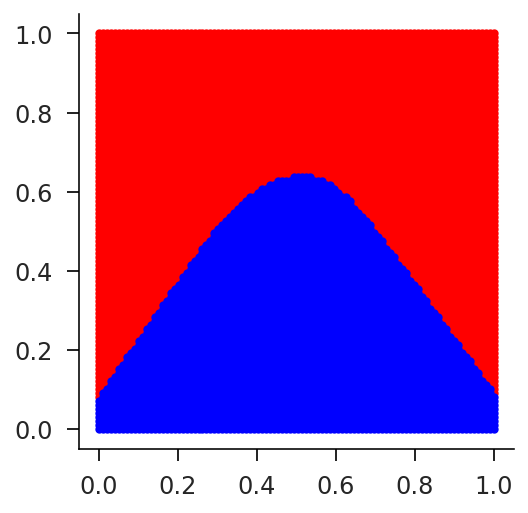

In [39]:
fig, ax = plt.subplots()
ax.scatter(test_red[:, 0], test_red[:, 1], color='red', s=10);
ax.scatter(test_blue[:, 0], test_blue[:, 1], color='blue', s=10);
plt.axis('square');

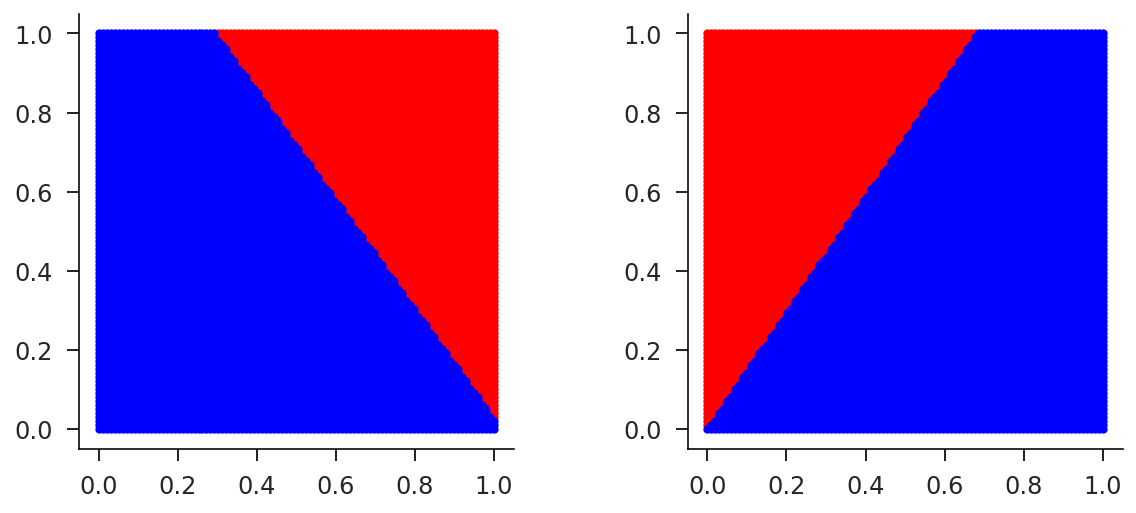

In [40]:
# get hidden layers
test_hidden = test_x @ est_W0 + est_b0 >= 0.0

# normalize by layer weight sign in final aggregation
layer_sign = est_W1 < 0
layer_mask0 = layer_sign[0] ^ test_hidden[:, 0]
layer_mask1 = layer_sign[1] ^ test_hidden[:, 1]

# get hidden outputs
test0_red = test_x[layer_mask0, :]
test0_blue = test_x[~layer_mask0, :]
test1_red = test_x[layer_mask1, :]
test1_blue = test_x[~layer_mask1, :]

# plot both
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4))
ax0.scatter(test0_red[:, 0], test0_red[:, 1], color='red', s=10);
ax0.scatter(test0_blue[:, 0], test0_blue[:, 1], color='blue', s=10);
ax1.scatter(test1_red[:, 0], test1_red[:, 1], color='red', s=10);
ax1.scatter(test1_blue[:, 0], test1_blue[:, 1], color='blue', s=10);
ax0.axis('square');
ax1.axis('square');

### Getting Fancy

In [41]:
# same neural as a module
bce_loss = torch.nn.CrossEntropyLoss()
class Neural(torch.nn.Module):
    def __init__(self, hid=2):
        super().__init__()
        self.linear0 = torch.nn.Linear(dim, hid)
        self.linear1 = torch.nn.Linear(hid, 2)
    def forward(self, x):
        x = self.linear0(x)
        x = torch.sigmoid(x)
        x = self.linear1(x)
        return x

In [42]:
# make dataset and loader
N = 10000
space = torch.randn(N, dim)
rando = torch.tensor(np.random.logistic(size=N))
categ = (true_beta0 + space @ true_beta1 + rando > 0).to(dtype=torch.long)
dataset = torch.utils.data.TensorDataset(space, categ)
dataload = torch.utils.data.DataLoader(dataset, batch_size=1000)

In [43]:
def fancy_stats(logits, y):
    predict = logits[:, 1] >= logits[:, 0]
    target = y == 1
    return torch.tensor([
        bool_mean(predict == target),
        bool_mean(predict & ~target),
        bool_mean(~predict & target),
    ])

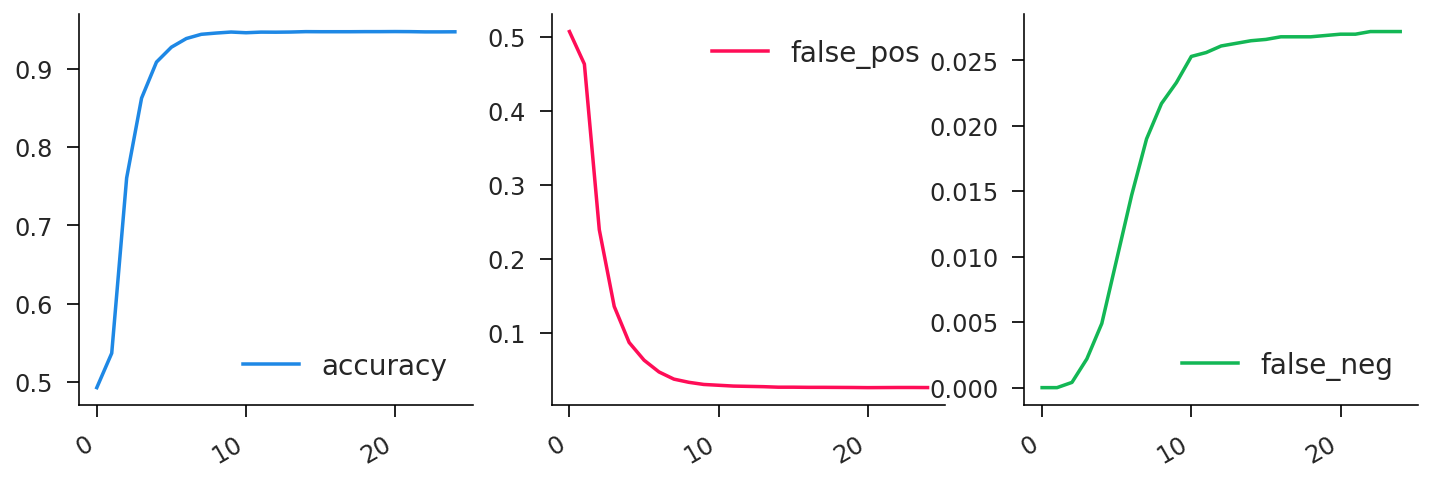

In [44]:
# make model and optimizer
model = Neural()
optim = torch.optim.Adam(model.parameters(), lr=0.01)

# track history
history = []

# go for many iterations
for i in range(25):
    # accumulate stats per batch
    nbatch = 0
    stats = torch.zeros(3)

    # iterate over batches
    for x, y in dataload:
        # compute loss
        logits = model(x)
        loss = bce_loss(logits, y)

        # update params
        optim.zero_grad()
        loss.backward()
        optim.step()

        # add batch stats
        nbatch += 1
        stats += fancy_stats(logits.detach(), y)

    # make it a mean    
    stats /= nbatch
    history.append(stats)

# turn history into dataframe
history = pd.DataFrame(
    torch.stack(history).numpy(),
    columns=['accuracy', 'false_pos', 'false_neg']
)
history.plot(subplots=True, layout=(1, 3), figsize=(12, 4));

## Overfitting

In [45]:
# parameters
N = 1000 # number of training series
M = 100 # number of validation series
T = 10 # total time length
L = 4 # sequence length
K = T - L # number of subseries

In [46]:
# generate overlapping sequences
def generate_sequences(vec, l):
    n, t = vec.shape
    k = t - l
    series = torch.stack([vec[:, i:i+l] for i in range(k)], axis=-1)
    series = series.transpose(1, 2).reshape((n*k, -1))
    target = vec[:, l:].reshape((n*k,))
    return series, target

In [47]:
# simple neural trader (long only)
class NeuralTrader(torch.nn.Module):
    def __init__(self, lag=4, hid=5):
        super().__init__()
        self.linear0 = torch.nn.Linear(lag, hid)
        self.linear1 = torch.nn.Linear(hid, 1)
    def forward(self, x):
        x = self.linear0(x)
        x = torch.sigmoid(x)
        x = self.linear1(x)
        x = torch.sigmoid(x)
        return x.squeeze()

In [48]:
def neural_trader(model, train_data, valid_data, lr=0.01, epochs=25, batch_size=1000):
    # make data loaders
    train_load = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
    valid_x, valid_y = valid_data.tensors

    # make model and optimizer
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # track history
    history = []

    # go for many iterations
    for i in range(epochs):
        n_batch = 0
        train_stats = torch.zeros(2)
        
        # iterate over batches
        for batch_x, batch_y in train_load:
            # compute loss
            recom = model(batch_x)
            retvrn = recom*batch_y
            loss = -retvrn.mean()

            # update params
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            # training stats
            n_batch += 1
            train_stats += torch.tensor([recom.detach().mean(), retvrn.detach().mean()])

        # average training
        train_stats /= n_batch

        # validation stats
        valid_recom = model(valid_x)
        valid_retvrn = valid_recom*valid_y
        valid_stats = torch.tensor([valid_recom.detach().mean(), valid_retvrn.detach().mean()])

        # make it a mean
        stats = torch.cat([train_stats, valid_stats])
        history.append(stats)

    # turn history into dataframe
    names = ['train_recom', 'train_return', 'valid_recom', 'valid_return']
    return pd.DataFrame(torch.stack(history).numpy(), columns=names)

In [49]:
# generate training data
train_return = torch.randn(N, T)
train_series, train_target = generate_sequences(train_return, L)
train_data = torch.utils.data.TensorDataset(train_series, train_target)

# generate validation data
valid_return = torch.randn(M, T)
valid_series, valid_target = generate_sequences(valid_return, L)
valid_data = torch.utils.data.TensorDataset(valid_series, valid_target)

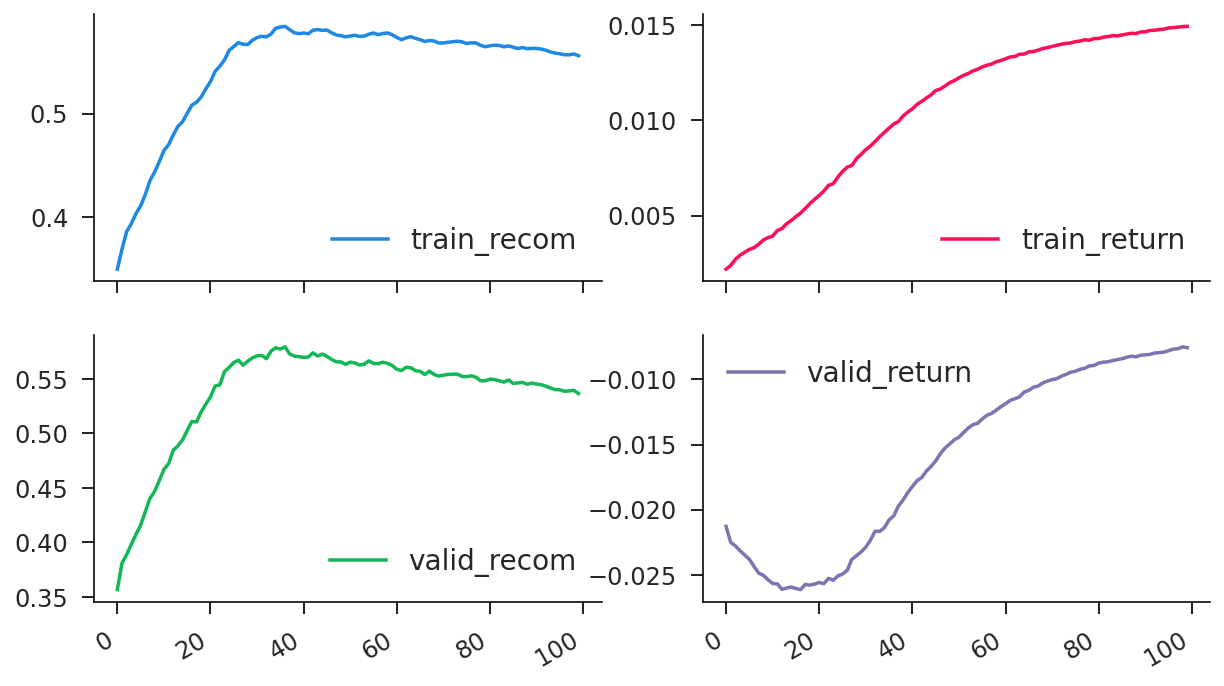

In [50]:
model_base = NeuralTrader(lag=L, hid=5)
history = neural_trader(model_base, train_data, valid_data, epochs=100)
history.plot(subplots=True, layout=(2, 2), figsize=(10, 6));

## With Momentum

In [51]:
momentum = 0.2

In [52]:
# generate training data
train_mean = momentum*torch.randn(N)
train_return = train_mean[:, None] + torch.randn(N, T)
train_series, train_target = generate_sequences(train_return, L)
train_data = torch.utils.data.TensorDataset(train_series, train_target)

# generate validation data
valid_mean = momentum*torch.randn(N)
valid_return = valid_mean[:, None] + torch.randn(N, T)
valid_series, valid_target = generate_sequences(valid_return, L)
valid_data = torch.utils.data.TensorDataset(valid_series, valid_target)

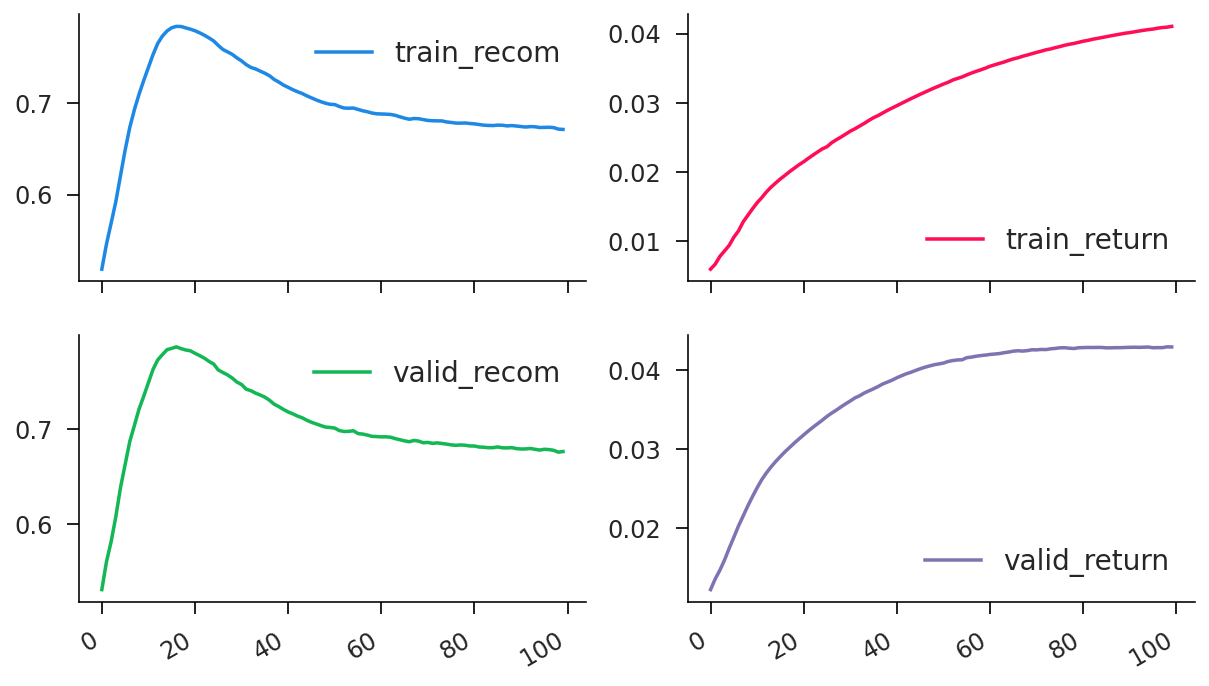

In [53]:
model_moment = NeuralTrader(lag=L, hid=5)
history = neural_trader(model_moment, train_data, valid_data, epochs=100)
history.plot(subplots=True, layout=(2, 2), figsize=(10, 6));

## Dropout

In [54]:
# simple neural trader (long only)
class DropoutTrader(torch.nn.Module):
    def __init__(self, lag=4, hid=5, drop=0.5):
        super().__init__()
        self.linear0 = torch.nn.Linear(lag, hid)
        self.linear1 = torch.nn.Linear(hid, 1)
        self.dropout = torch.nn.Dropout(drop)
        self.drop = drop
    def forward(self, x):
        x = self.linear0(x)
        x = torch.sigmoid(x)
        x = self.dropout(x)
        x = self.linear1(x)
        x = torch.sigmoid(x)
        return x.squeeze()

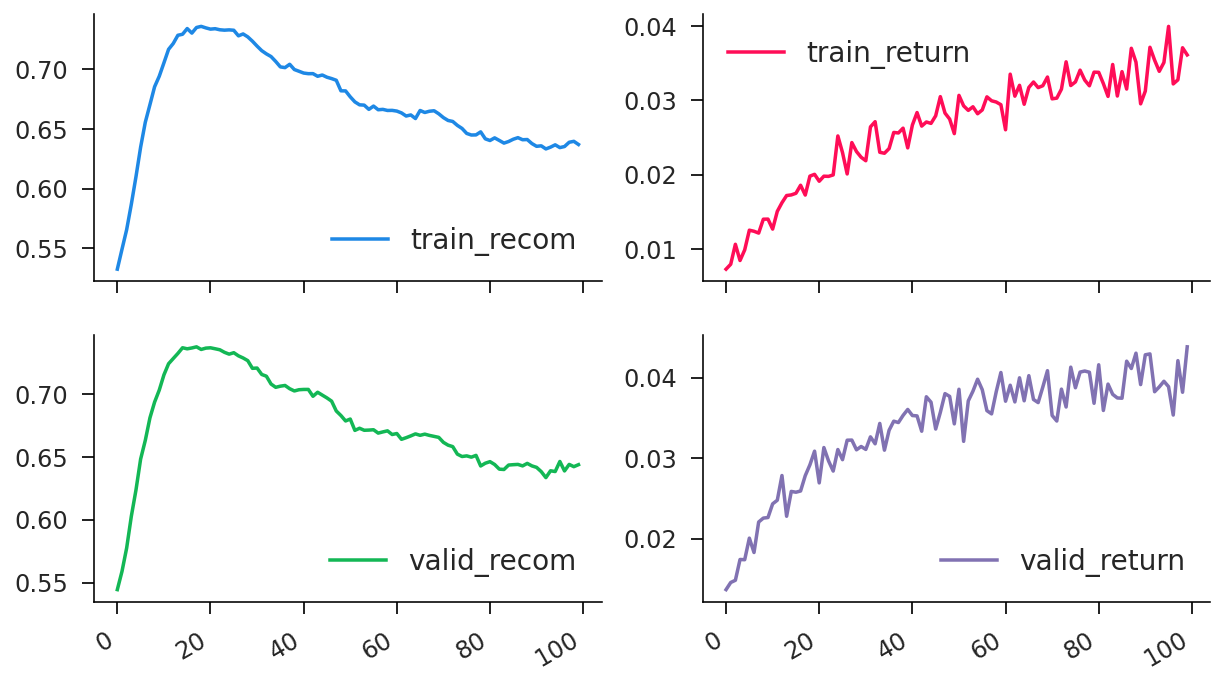

In [55]:
model_dropout = DropoutTrader(lag=L, hid=5, drop=0.5)
history = neural_trader(model_dropout, train_data, valid_data, epochs=100)
history.plot(subplots=True, layout=(2, 2), figsize=(10, 6));

## Text Analysis

In [7]:
import os
import re
import json
import time
import html

In [8]:
import sklearn.feature_extraction.text as fe
from sklearn.model_selection import train_test_split
import tflearn
from tflearn.data_utils import to_categorical

In [9]:
def clean_tweet(text):
    text = text.lower().strip()

    # odd subs
    text = re.sub(r'’', '\'', text)
    text = re.sub(r'—', '-', text)

    # urls
    text = re.sub(r'\bhttps?://[\S]*\b', r' ', text)
    text = html.unescape(text)

    # acronyms
    text = re.sub(r'\.{2,}', r'.', text)
    text = re.sub(r'(\S)\.(\S)\.', r'\1\2', text)
    text = re.sub(r'(\S)\.(\S)\.(\S)\.', r'\1\2\3', text)

    # control chars
    text = re.sub(r'([!\.&,])', r' \1 ', text)
    text = re.sub(r'[^ a-z0-9#@!\.&,\']', r' ', text)
    text = re.sub(r'[0-9\']', r'', text)

    # clean up
    text = re.sub(r' {2,}', r' ', text)
    text = text.strip()

    # combine
    return text

In [10]:
# load data for 2016 and 2017
trump_dir = '/media/Liquid/data/tweets/trump_tweet_data_archive'
tweets16 = pd.read_json(os.path.join(trump_dir, 'condensed_2016.json'))
tweets17 = pd.read_json(os.path.join(trump_dir, 'condensed_2017.json'))
tweets = pd.concat([tweets16, tweets17])

# get rid of quote tweets and retweets
rt_mark = tweets['text'].apply(lambda s: s.startswith('"@') or s.startswith('rt'))
tweets = tweets[(~tweets['is_retweet'])&(~rt_mark)&tweets['in_reply_to_user_id_str'].isnull()]
tweets['isource'] = tweets['source'].map({'Twitter for iPhone': 0, 'Twitter for Android': 1})
tweets = tweets.dropna(subset=['isource'])
tweets['isource'] = tweets['isource'].astype(np.int)

# prune down text to basic words
tweets['clean_text'] = tweets['text'].apply(clean_tweet)

In [11]:
# collect input/output data, output is categorical
corpus = list(tweets['clean_text'])
categ = to_categorical(tweets['isource'].values, 2)
print(len(corpus))

3460


In [12]:
# text complexity
all_text = ' '.join(corpus)
all_toks = all_text.split()
all_vocab = list(set(all_toks))
num_toks = len(all_toks)
num_wrds = len(all_vocab)
print(f'total words: {num_toks}')
print(f'distinct words: {num_wrds}')
print(f'ratio = {num_wrds/num_toks}')

total words: 67000
distinct words: 5622
ratio = 0.08391044776119402


In [13]:
# vectorize words weighting them with Tf-Idf scheme
tfidf = fe.TfidfVectorizer()
counts = tfidf.fit_transform(corpus).todense()
n_twt, n_wrd = counts.shape
print(f'n_twt = {n_twt}, n_wrd = {n_wrd}')

n_twt = 3460, n_wrd = 5537


In [14]:
# set aside 10% of data for validation
(train_x, valid_x, train_y, valid_y) = train_test_split(counts, categ, test_size=0.1)

In [15]:
# function to generate a neural network
def generate_nn(n_wrd, nn_size, dropout):
    net = tflearn.input_data([None, n_wrd])
    net = tflearn.fully_connected(net, nn_size, activation='softmax')
    net = tflearn.dropout(net, 1-dropout)
    net = tflearn.fully_connected(net, 2, activation='softmax')
    net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')
    model = tflearn.DNN(net, clip_gradients=0.0, tensorboard_verbose=1,
        tensorboard_dir='/tmp/tflearn_logs/neural', checkpoint_path='checkpoints/neural')
    return model

In [16]:
tf.reset_default_graph()
model = generate_nn(n_wrd, 128, 0.5)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [17]:
run_id = 'neural_%s' % time.strftime('%Y_%m%d_%H%M')
model.fit(train_x, train_y, validation_set=(valid_x, valid_y),
          show_metric=True, n_epoch=25, run_id=run_id)

Training Step: 1224  | total loss: 0.39070 | time: 1.122s
| Adam | epoch: 025 | loss: 0.39070 - acc: 0.8803 -- iter: 3072/3114
Training Step: 1225  | total loss: 0.38862 | time: 2.151s
| Adam | epoch: 025 | loss: 0.38862 - acc: 0.8813 | val_loss: 0.44592 - val_acc: 0.8382 -- iter: 3114/3114
--
INFO:tensorflow:/media/Liquid/work/data_science/checkpoints/neural-1225 is not in all_model_checkpoint_paths. Manually adding it.


In [18]:
all_prob = model.predict(counts)
android_prob = all_prob[:, 1]
androidy = list(tweets['text'].iloc[android_prob.argsort()[::-1]])

In [19]:
print('\n\n'.join(androidy[:5]))

Only reason the hacking of the poorly defended DNC is discussed is that the loss by the Dems was so big that they are totally embarrassed!

Why doesn't the media want to report that on the two "Big Thursdays" when Crooked Hillary and I made our speeches - Republican's won ratings

Ted Cruz didn't win Iowa, he stole it. That is why all of the polls were so wrong and why he got far more votes than anticipated. Bad!

Hillary and the Dems were never going to beat the PASSION of my voters. They saw what was happening in the last two weeks before the......

I said that Crooked Hillary Clinton is "not qualified" to be president because she has "very bad judgement" - Bernie said the same thing!


In [20]:
print('\n\n'.join(androidy[-5:]))

Thank you America! #Trump2016
#MakeAmericaGreatAgain https://t.co/8B0J8Xt3dh

THANK YOU AMERICA! 
#MakeAmericaGreatAgain #Trump2016 https://t.co/TRrdR0nlpM

Thank you, America!
#MakeAmericaGreatAgain #Trump2016 https://t.co/7xxWD0au9H

THANK YOU, AMERICA! #Trump2016
#MakeAmericaGreatAgain 
https://t.co/09hTbBgPHf https://t.co/uJnmDnvkUv

THANK YOU!  
#MakeAmericaGreatAgain #Trump2016
https://t.co/nvgOPoo5qf https://t.co/0JCjfbcpJZ


## Long Short-Term Memory (LSTM)

### WARNING: This section is pretty memory intensive.

In [21]:
from tflearn.data_utils import string_to_semi_redundant_sequences, \
    textfile_to_semi_redundant_sequences, random_sequence_from_textfile

In [22]:
maxlen = 25 # length of memory
redun = 3 # stride in data reading
units = 512 # number of hidden units

Moby Dick full text from Project Gutenberg:
https://www.gutenberg.org/files/2701/2701-0.txt

In [26]:
# read in the book
path = os.path.join('data/moby_dick.txt')

# for storing parameters
chk_path = os.path.join('checkpoints/mobydick')

In [27]:
# load corpus text
X, Y, char_idx = textfile_to_semi_redundant_sequences(path, seq_maxlen=maxlen, redun_step=redun)

Vectorizing text...
Text total length: 1,235,186
Distinct chars   : 86
Total sequences  : 411,721


In [30]:
# define model
tf.reset_default_graph()
g = tflearn.input_data([None, maxlen, len(char_idx)])
g = tflearn.lstm(g, units, return_seq=True)
g = tflearn.dropout(g, 0.5)
g = tflearn.lstm(g, units, return_seq=True)
g = tflearn.dropout(g, 0.5)
g = tflearn.lstm(g, units)
g = tflearn.dropout(g, 0.5)
g = tflearn.fully_connected(g, len(char_idx), activation='softmax')
g = tflearn.regression(g, optimizer='adam', loss='categorical_crossentropy',
                       learning_rate=0.001)
m = tflearn.SequenceGenerator(g, dictionary=char_idx, seq_maxlen=maxlen,
                              clip_gradients=5.0, checkpoint_path=chk_path)

In [31]:
# train model
m.fit(X, Y, validation_set=0.1, batch_size=1024, n_epoch=10, run_id='mobydick')

Training Step: 3619  | total loss: 2.10010 | time: 193.451s
| Adam | epoch: 010 | loss: 2.10010 -- iter: 369664/370548
Training Step: 3620  | total loss: 2.09375 | time: 206.288s
| Adam | epoch: 010 | loss: 2.09375 | val_loss: 2.00553 -- iter: 370548/370548
--
INFO:tensorflow:/media/Liquid/work/data_science/checkpoints/mobydick-3620 is not in all_model_checkpoint_paths. Manually adding it.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


In [7]:
# load a checkpoint
m.load(os.path.join(chk_dir, 'mobydick-3620'))

INFO:tensorflow:Restoring parameters from /media/Liquid/work/notebooks/moby_checkpoints/model_mobydick-3620


In [32]:
seed = random_sequence_from_textfile(path, maxlen)
print(m.generate(600, temperature=0.5, seq_seed=seed))

ead wood has the better of the sace the shoriwing and the fhane of the shound but the clanded as he colmatering an hele the bode to in the captare what ming but of the leen the care the sharp sush the sire to the seed of the wher seen in that man a manter the silling the porpent nest of sorter the see and the chane san in the when seeming the shall the male the shout the cole of the whale and with it in the crood the spopsing of had the shill the seas the whale sheeg that so nean of the such the fare of the sech mor all this was now the sean such coarsed with the should, so mingle of his une that the catter as of the 


In [33]:
seed = random_sequence_from_textfile(path, maxlen)
print(m.generate(600, temperature=1.0, seq_seed=seed))

ed to that languid breezer the
rinkingm ot mad, Semimes spear nown iffoisker the samreavet yor no the high Ill sesselll wowe llenfita, stralbe an Im arount deetn, and to de at the sanmy Ivabe f,aken of thome at yoe
Sor in
the lniund--porncpithtin of yerp'ngeates and leckior. 
Fish a Hatt the have wis eede Bigilacaoonacl and mor Kaying
of AYter of ndeqt. So tis ly the skew out has, in younds on Fhems, thay lecule in to his archas calls the brurper the Pexp?"  strels.

"Peer, and boeg aran lort but absou weed not Inpme ti lode tall len,", sor a how he feipa Ye af Poung
of whiif Ind fip spwo day. fele. The more. Oud! fil


In [34]:
# evaluate probability of a string
k = 128
def find_like(s):
    X0, Y0, _ = string_to_semi_redundant_sequences(s, seq_maxlen=maxlen, redun_step=1, char_idx=char_idx)
    tlen = len(s) - maxlen
    pred = np.vstack([m.evaluate(X0[i:i+k,:,:], Y0[i:i+k,:]) for i in range(0, tlen, k)])
    like = np.mean(np.log([pred[i, char_idx[x]] for i, x in enumerate(s[maxlen:])]))
    return like

In [35]:
find_like('Four score and seven years ago our fathers brought forth on this continent,'
          ' a new nation, conceived in Liberty, and dedicated to the proposition that '
          'all men are created equal.')

Vectorizing text...
Text total length: 176
Distinct chars   : 86
Total sequences  : 151


-1.9319848

In [36]:
find_like(' '.join(100*['whale']))

Vectorizing text...
Text total length: 599
Distinct chars   : 86
Total sequences  : 574


-1.0066937

In [37]:
# words per character
import re
moby_text = open(path).read()
moby_text = moby_text.lower().replace('\n', ' ')
moby_text = re.sub(r'[^a-z ]', r'', moby_text)
moby_text = re.sub(r' +', ' ', moby_text).strip()
moby_toks = moby_text.split()
vocab = list(set(moby_toks))
n_toks = len(moby_toks)
n_wrds = len(vocab)
print(f'total words: {n_toks}')
print(f'distinct words: {n_wrds}')
print(f'ratio = {n_wrds/n_toks}')

total words: 214871
distinct words: 19973
ratio = 0.09295344648649655
